In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [2]:
# parsed the dates right at the beginning 
# works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3


## 9.1 Simulative approach to calculate SIR curves

- The SIR model is a simple model, due to Kermack and McKendrick, of an epidemic of an infectious disease in a large population. We assume the population consists of three types of individuals, whose numbers are denoted by the letters S(suspectible), I (infected)and R (recovered).
- To check SIR model, click on the link: SIR Model for Spread of Disease.

In [3]:
# basic parameters set
# beta/gamma is denoted as 'basic reproduction number'

N0=1000000 # max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [4]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

In [5]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

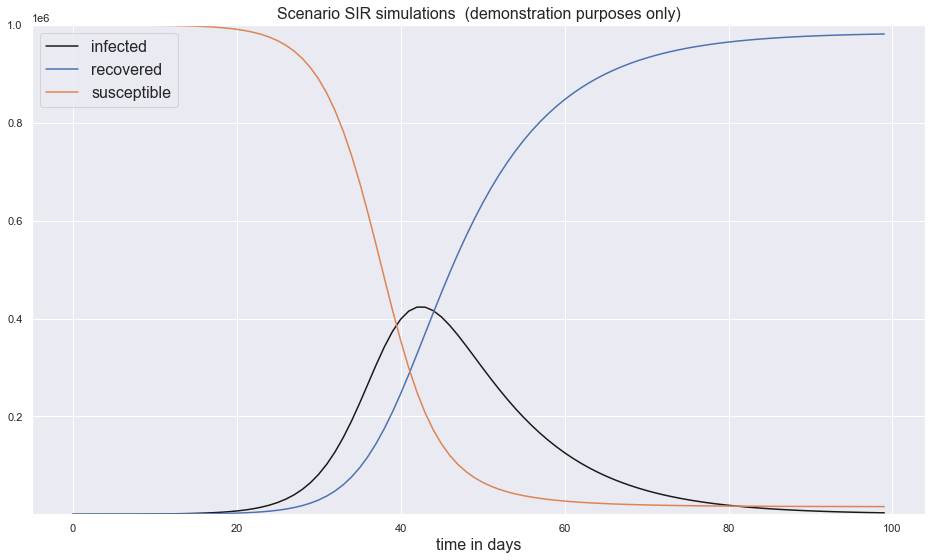

In [6]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Scenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting parameters of SIR model

- [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
- [scipy.integrate.odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)

In [7]:
ydata = np.array(df_analyse.Germany[35:])
t = np.arange(len(ydata))

# Re-initialization
I0=ydata[0]
S0=N0-I0
R0=0
beta = 0.4
gamma = 0.1

In [8]:
def SIR_model_t(SIR, t, beta, gamma):
    ''' Simple SIR model
        S: Susceptible population
        I: Infected people
        R: Recovered people
        beta: Infection spread dynamics
        gamma: Recovery rate
        
        overall condition is that the sum of changes(differnces) sum up to 0
        dS+dI+dR=0
        
        S+I+R= N (constant size of population)
    
    '''
    S,I,R=SIR
    dS_dt = -beta*I*S/N0
    dI_dt = beta*I*S/N0 - gamma*I
    dR_dt = gamma*I
    
    return dS_dt, dI_dt, dR_dt

In [9]:
def fit_odeint(x, beta, gamma):
    '''
    Helper function for the integration
    '''    
    return integrate.odeint(SIR_model_t, (S0, I0, R0), x, args=(beta, gamma))[:,1] # We are interested only in dI

In [10]:
# Example curve of our differential equation
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([2.70000000e+01, 3.64457071e+01, 4.91956207e+01, 6.64053493e+01,
       8.96344660e+01, 1.20987564e+02, 1.63304428e+02, 2.20416326e+02,
       2.97491205e+02, 4.01498275e+02, 5.41832616e+02, 7.31153728e+02,
       9.86509149e+02, 1.33083608e+03, 1.79496099e+03, 2.42024936e+03,
       3.26209305e+03, 4.39445723e+03, 5.91573047e+03, 7.95611026e+03,
       1.06866705e+04, 1.43300301e+04, 1.91720581e+04, 2.55731545e+04,
       3.39761277e+04, 4.49053964e+04, 5.89492486e+04, 7.67139399e+04,
       9.87375269e+04, 1.25356226e+05, 1.56531317e+05, 1.91671801e+05,
       2.29519056e+05, 2.68172791e+05, 3.05306626e+05, 3.38543581e+05,
       3.65876662e+05, 3.85989183e+05, 3.98379367e+05, 4.03287154e+05,
       4.01494345e+05, 3.94088591e+05, 3.82258097e+05, 3.67146745e+05,
       3.49770632e+05, 3.30982618e+05, 3.11468385e+05, 2.91760020e+05,
       2.72257377e+05, 2.53251232e+05, 2.34945074e+05, 2.17474127e+05,
       2.00921199e+05, 1.85329524e+05, 1.70712933e+05, 1.57063815e+05,
      

In [11]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

<ipython-input-8-baf5a3579d1d>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt = -beta*I*S/N0
<ipython-input-8-baf5a3579d1d>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt = beta*I*S/N0 - gamma*I
C:\Users\SurabhiD\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\SurabhiD\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00337514 0.00314058]  start infect: 27
Optimal parameters: beta = 0.17492580850599934  and gamma =  0.06442634193068934


In [12]:
# Get the final fitted curve
fitted=fit_odeint(t, *popt)

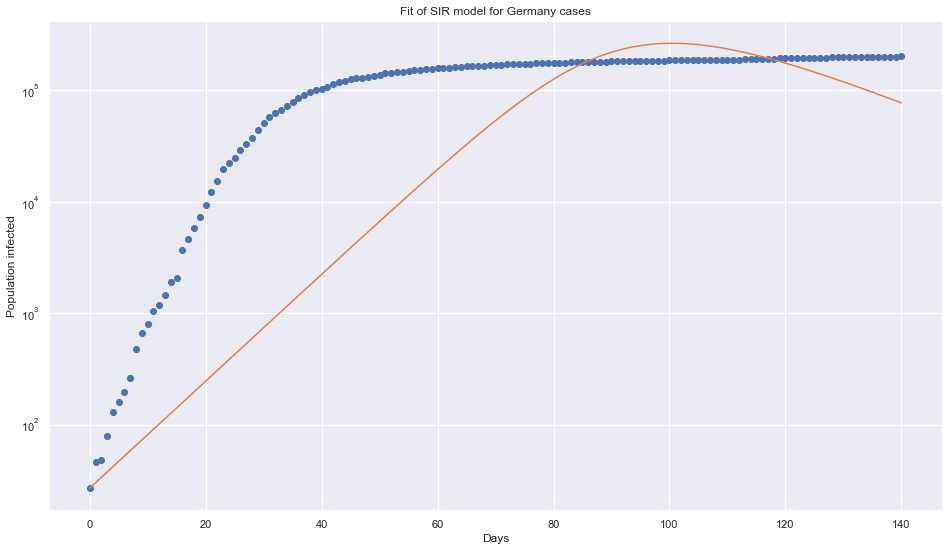

Optimal parameters: beta = 0.17492580850599934  and gamma =  0.06442634193068934
Basic Reproduction Number R0  2.7151286766240226
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [13]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Dynamic beta in SIR (Infection Rate)

- Consider the change in beta according to behaviour of people

In [14]:
t_initial=25           # Initial days, people are not much aware 
t_intro_measures=10    # For this period people start to take precautions
t_hold=20              # People still take precautions
t_relax=30             # People start relaxing and do not take precautions

beta_max=0.4
beta_min=0.11
gamma=0.1

# Calculate beta for each day
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))

In [15]:
pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.36777778, 0.33555556, 0.30333333, 0.27111111,
       0.23888889, 0.20666667, 0.17444444, 0.14222222, 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.12      , 0.13      , 0.14      , 0.15      ,
       0.16      , 0.17      , 0.18      , 0.19      , 0.2       ,
       0.21      , 0.22      , 0.23      , 0.24      , 0.25      ,
       0.26      , 0.27      , 0.28      , 0.29      , 0.3    

In [16]:
SIR=np.array([S0,I0,R0])

propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})

for each_beta in pd_beta:
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
    SIR=SIR+new_delta_vec
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

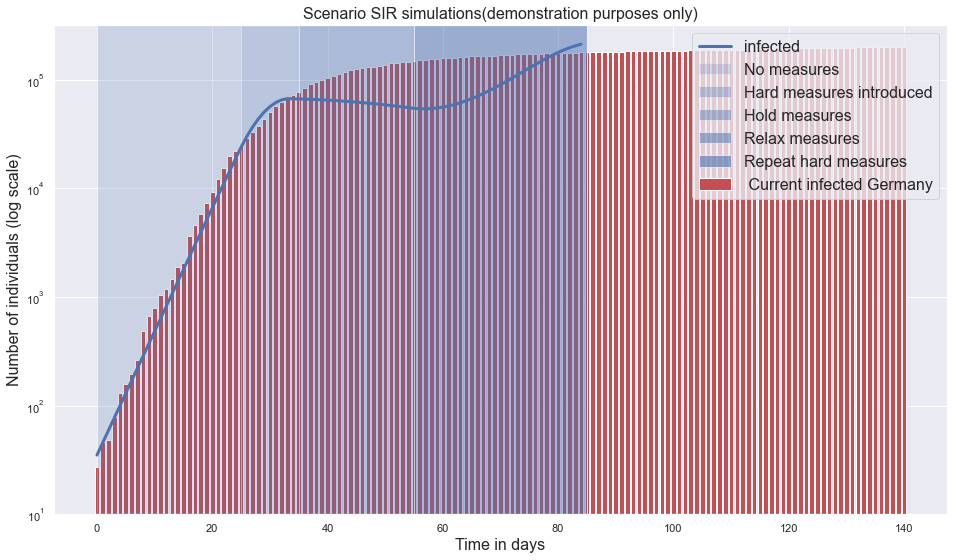

In [17]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' Current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='No measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='Hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='Hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='Relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='Repeat hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Scenario SIR simulations(demonstration purposes only)',size=16)
ax1.set_xlabel('Time in days',size=16)
ax1.set_ylabel('Number of individuals (log scale)',size=16)
ax1.legend(loc='best',
           prop={'size': 16});